In [1]:
#Gives sum of next 30 days output expected
#Need to make it better ie. more ma vars. #Add 2 years in past as well
#Try polynomial predictor. 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)
from sklearn.ensemble import GradientBoostingRegressor


In [2]:
electricity_ng = pd.read_csv('Dataset/PV_Elec_Gas2.csv').rename(columns={'Unnamed: 0': 'Date'})
solar_output = pd.read_csv('Dataset/solarpower_cumuldaybyday2.csv').drop(columns='Unnamed: 2')


In [3]:
def get_month(x):
    date = datetime.strptime(x, "%Y-%m-%d")
    month = date.month
    return month
def get_yr(x):
    date = datetime.strptime(x, "%Y-%m-%d")
    year = date.year
    return year
def get_day(x):
    date = datetime.strptime(x, "%Y-%m-%d")
    day = date.day
    return day

def days_change(x,y):
    date_1 = datetime.strptime(x, "%Y-%m-%d")
    date_2 = datetime.strptime(y, "%Y-%m-%d")
    chng = (date_2 - date_1).days
    return chng

electricity_ng['month'] = electricity_ng['Date'].apply(get_month)
electricity_ng['year'] = electricity_ng['Date'].apply(get_yr)
electricity_ng['yesterday_power'] = electricity_ng['cum_power'].shift(1)
electricity_ng['yesterday'] = electricity_ng['Date'].shift(1)
electricity_ng = electricity_ng.dropna()
electricity_ng
electricity_ng['days'] = electricity_ng.apply(lambda x: days_change(x['yesterday'], x['Date']),axis=1)
electricity_ng['output/day'] = (electricity_ng['cum_power'] - electricity_ng['yesterday_power'])/electricity_ng['days']
electricity_ng['day_of_month'] = electricity_ng['Date'].apply(get_day)



analyze = electricity_ng[['Date','year', 'month', 'day_of_month', 'output/day']]
analyze['target'] = analyze['output/day'].shift(-1)
analyze['target'] = analyze['target'].shift(-30).rolling(window=30).sum()
#analyze

#analyze.to_csv('check.csv')



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [4]:
def mv_avg(df):
    mvg_avg_lst = [2,3,4,5,7,10,15,20,25,30,45]
    for i in mvg_avg_lst:
        column_name = 'mv_avg_' + str(i)
        df[column_name] = df.iloc[:,4].rolling(window=i).mean()
    return df
# df = mv_avg(analyze)
# df[df['year']==2013]


In [5]:
#Get moving average this time last year and 1 year before for each date
def year_over_yr(data):
    yr = 2011
    yrs = {}
    target = data[['year', 'month', 'day_of_month', 'target']].copy()
    data = data.drop(columns ='target')
    for i in range(0, (max(data['year']) - yr) + 1):
        frame_name = 'year' + str(yr) + 'data' 
        yrs[frame_name] = data[data['year']==yr]
        yr +=1

    
    #Get_last year
    data_set = {}
    for item in [2013,2014,2015,2016,2017,2018,2019]:
        last_yr = item-1
        lst_yr = 'year' + str(last_yr) + 'data' 
        this_yr = 'year' + str(item) + 'data' 
        
        data_last_year = yrs[lst_yr]
        
        
        for column in data_last_year.columns:
            if 'mv_avg' in column:
                data_last_year = data_last_year.rename(columns={column: 'lst_yr_' + str(column)})

        data_this_year = yrs[this_yr]
        iter_frame = pd.DataFrame()
        data_last_year = data_last_year.drop(columns=['Date', 'year', 'output/day'])
        data_this_year =  data_this_year.drop(columns=['Date', 'year'])
        iter_frame = pd.merge(data_this_year,data_last_year, on =['month', 'day_of_month'], how='left')
        iter_frame.insert(0, 'year', item)
        
        data_set[item] = iter_frame

    final_frame = pd.DataFrame()
    i = 0
    for item in data_set.keys():
        if i == 0:
            final_frame = data_set[item]    
            i+=1
            continue
        final_frame = final_frame.append(data_set[item])
  
    final_frame = pd.merge(final_frame,target, on =['year', 'month', 'day_of_month'],how='left')
    final_frame = final_frame.sort_values(by=['year', 'month', 'day_of_month'], ascending=True)
    return final_frame


# df1 = year_over_yr(df)
# df1[(df1['month']==1) & (df1['year']==2013)]


In [6]:
def day_dums(data):

    data = data[data['year']> 2012]
    day = [0,5,10,15,20,25,33]
    day_buckets = pd.DataFrame()
    for j in range(0,len(day)):
        start = day[j]
        if j != len(day)-1:
            end = day[j+1]
        else:
            continue
        c_n = 'day>=_' + str(start)+ '_day_<' + str(end)
        day_buckets[c_n] = data.apply(lambda x: 1 if x['day_of_month'] >= start and x['day_of_month'] < end else 0,axis=1)
    day_buckets
    pd.set_option('display.max_rows',300)
    dummies = day_buckets
    merger_data = data[['year', 'month', 'day_of_month']]
    month_dummies = pd.get_dummies(data[data['year']>2012]['month'])
    Trans_frm = merger_data.join(month_dummies)
    Trans_frm = Trans_frm.join(dummies)
    
    return Trans_frm




In [7]:
def pipeline(dataframe):
    dummies = day_dums(dataframe)
    T_1 = mv_avg(dataframe)
    T_2 = year_over_yr(T_1)
    T = pd.merge(dummies, T_2, on=['year', 'month', 'day_of_month'],how='outer')
    return T
pd.set_option("display.max_rows",300)


data = pipeline(analyze)
#display(data.head(5))


train = data[data['year'] < 2019]
train = train[(train['month']!=2) | (train['day_of_month']!= 29)]
test = data[data['year']==2019]
train[pd.isnull(train).any(axis=1)]
y = train.pop('target')
train

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,year,month,day_of_month,1,2,3,4,5,6,7,8,9,10,11,12,day>=_0_day_<5,day>=_5_day_<10,day>=_10_day_<15,day>=_15_day_<20,day>=_20_day_<25,day>=_25_day_<33,output/day,mv_avg_2,mv_avg_3,mv_avg_4,mv_avg_5,mv_avg_7,mv_avg_10,mv_avg_15,mv_avg_20,mv_avg_25,mv_avg_30,mv_avg_45,lst_yr_mv_avg_2,lst_yr_mv_avg_3,lst_yr_mv_avg_4,lst_yr_mv_avg_5,lst_yr_mv_avg_7,lst_yr_mv_avg_10,lst_yr_mv_avg_15,lst_yr_mv_avg_20,lst_yr_mv_avg_25,lst_yr_mv_avg_30,lst_yr_mv_avg_45
0,2013,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1.1,1.75,2.133333,1.850,1.76,1.785714,1.49,1.413333,1.620,1.836,1.780000,2.031111,2.05,1.666667,1.375,1.20,1.000000,1.14,1.660000,1.585,1.848,1.820000,2.320000
1,2013,1,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2.7,1.90,2.066667,2.275,2.02,1.857143,1.74,1.526667,1.515,1.876,1.770000,2.068889,0.65,1.633333,1.450,1.26,1.028571,1.13,1.473333,1.485,1.820,1.760000,2.293333
2,2013,1,3,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2.4,2.55,2.066667,2.150,2.30,1.985714,1.95,1.600000,1.490,1.776,1.836667,2.084444,1.85,1.400000,1.950,1.74,1.385714,1.30,1.380000,1.565,1.872,1.836667,2.220000
3,2013,1,4,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.6,1.50,1.900000,1.700,1.84,1.871429,1.82,1.500000,1.480,1.788,1.796667,2.055556,1.85,1.500000,1.250,1.72,1.428571,1.15,1.306667,1.555,1.712,1.830000,2.104444
4,2013,1,5,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.4,0.50,1.133333,1.525,1.44,1.785714,1.64,1.486667,1.430,1.748,1.783333,1.968889,1.75,2.133333,1.800,1.54,1.742857,1.36,1.300000,1.615,1.652,1.836667,2.031111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2186,2018,12,27,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,4.0,4.00,3.666667,2.750,2.80,2.285714,2.50,2.533333,2.400,2.160,2.166667,2.622222,1.00,1.000000,0.750,0.80,0.714286,1.00,1.133333,1.100,1.120,1.133333,1.733333
2187,2018,12,28,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,2.0,3.00,3.333333,3.250,2.60,2.428571,2.20,2.333333,2.450,2.160,2.133333,2.622222,1.50,1.333333,1.250,1.00,0.857143,1.00,1.200000,1.200,1.160,1.200000,1.711111
2188,2018,12,29,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1.0,1.50,2.333333,2.750,2.80,2.428571,2.10,2.133333,2.450,2.160,2.133333,2.511111,2.50,2.000000,1.750,1.60,1.285714,1.10,1.400000,1.200,1.240,1.233333,1.644444
2189,2018,12,30,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1.0,1.00,1.333333,2.000,2.40,2.142857,2.00,2.133333,2.400,2.120,2.100000,2.422222,1.50,1.666667,1.500,1.40,1.142857,1.00,1.200000,1.100,1.160,1.166667,1.600000


In [8]:
from sklearn.linear_model import LinearRegression
train = train.drop(columns=['year', 'month', 'day_of_month'])

x = train.values
mod = LinearRegression().fit(x, y)
mod.score(x, y)


#With linear coeff of determinaton = 0.95

0.9525617608366747

In [9]:
# test
actual = test.pop('target')
meta = test[['year', 'month', 'day_of_month']]
test = test.drop(columns=['year', 'month', 'day_of_month'])

pred = mod.predict(test.values)

In [18]:
anal_ize = pd.DataFrame()
anal_ize['actual'] = actual
anal_ize['predicted'] = pred
anal_ize['error'] = abs(anal_ize['actual'] -anal_ize['predicted'])
anal_ize = meta.join(anal_ize)
anal_ize['error'].sum()
anal_ize = anal_ize.dropna()
anal_ize

,year,month,day_of_month,actual,predicted,error
2191,2019,1,1,65.0,102.289062,37.289062
2192,2019,1,2,66.0,101.261719,35.261719
2193,2019,1,3,65.0,100.930664,35.930664
2194,2019,1,4,67.0,101.716797,34.716797
2195,2019,1,5,69.0,101.197266,32.197266
2196,2019,1,6,71.0,101.263672,30.263672
2197,2019,1,7,72.0,100.912109,28.912109
2198,2019,1,8,76.0,101.749023,25.749023
2199,2019,1,9,73.0,100.951172,27.951172
2200,2019,1,10,75.0,102.710938,27.710938


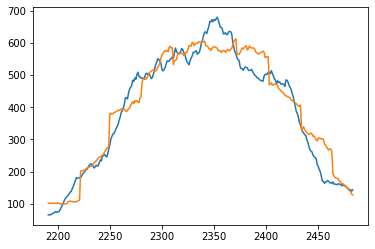

In [19]:
# x = anal_ize['actual']
x = anal_ize.index
y1 = anal_ize['actual']
y2 = anal_ize['predicted']
plt.plot(x,y1)
plt.plot(x,y2)

In [22]:
anal_ize['%err'] = anal_ize['error']/anal_ize['actual']
anal_ize['%err'].mean()
#anal_ize[anal_ize['month']==6]

0.1334559227848833